<a href="https://colab.research.google.com/github/samer-glitch/Leveraging-Machine-Learning-for-Identifying-and-Classifying-Cyber-Threats-in-Network-Environments/blob/main/Volume%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv to Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv


<ipython-input-52-d5ee92c4d1b4>:8: DtypeWarning: Columns (0,2,4,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')


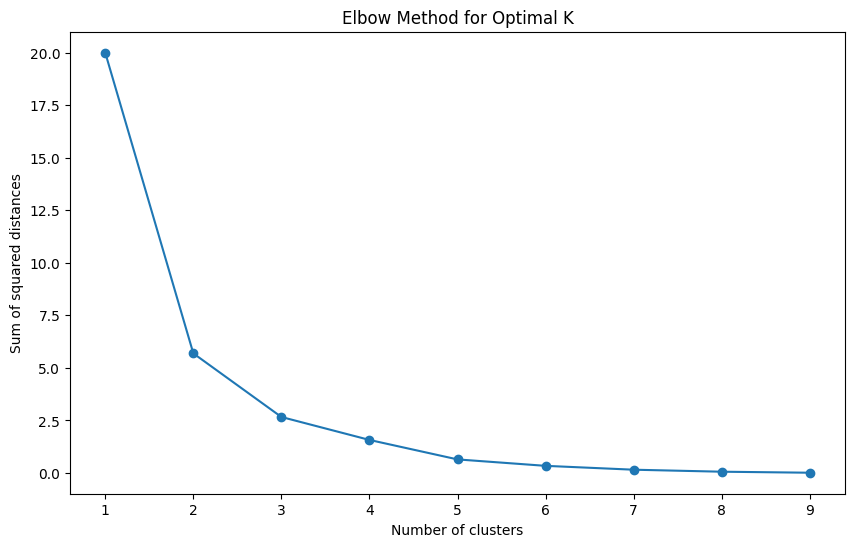

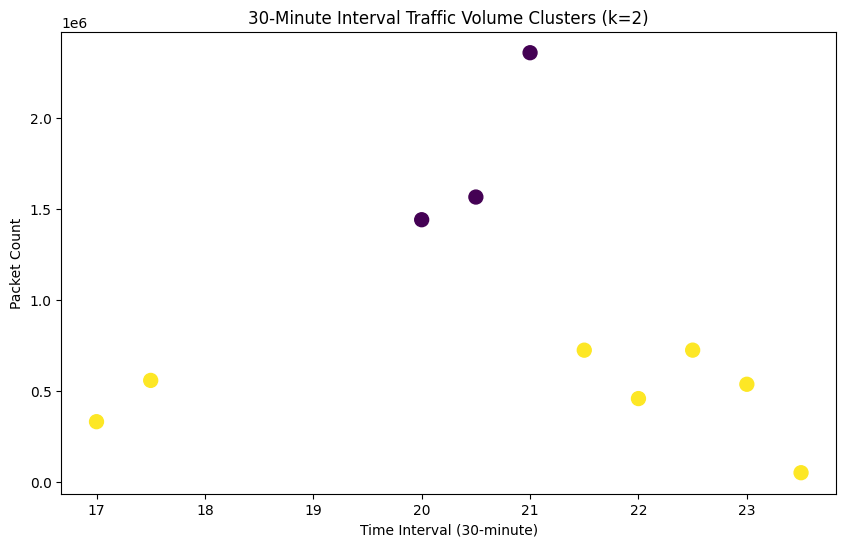

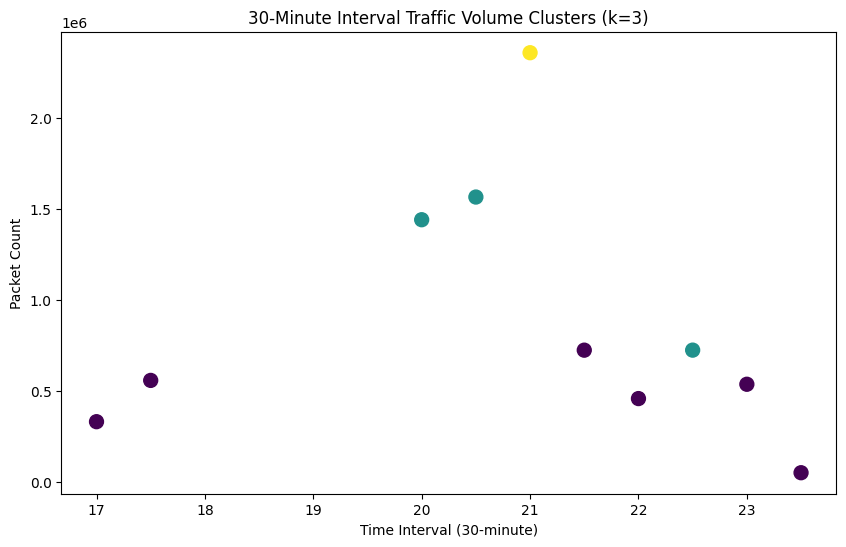


Average packet count for clusters (k=2):
Cluster 0: 1787478.6666666667
Cluster 1: 483175.28571428574

Average packet count for clusters (k=3):
Cluster 0: 443029.0
Cluster 1: 1243034.0
Cluster 2: 2357387.0


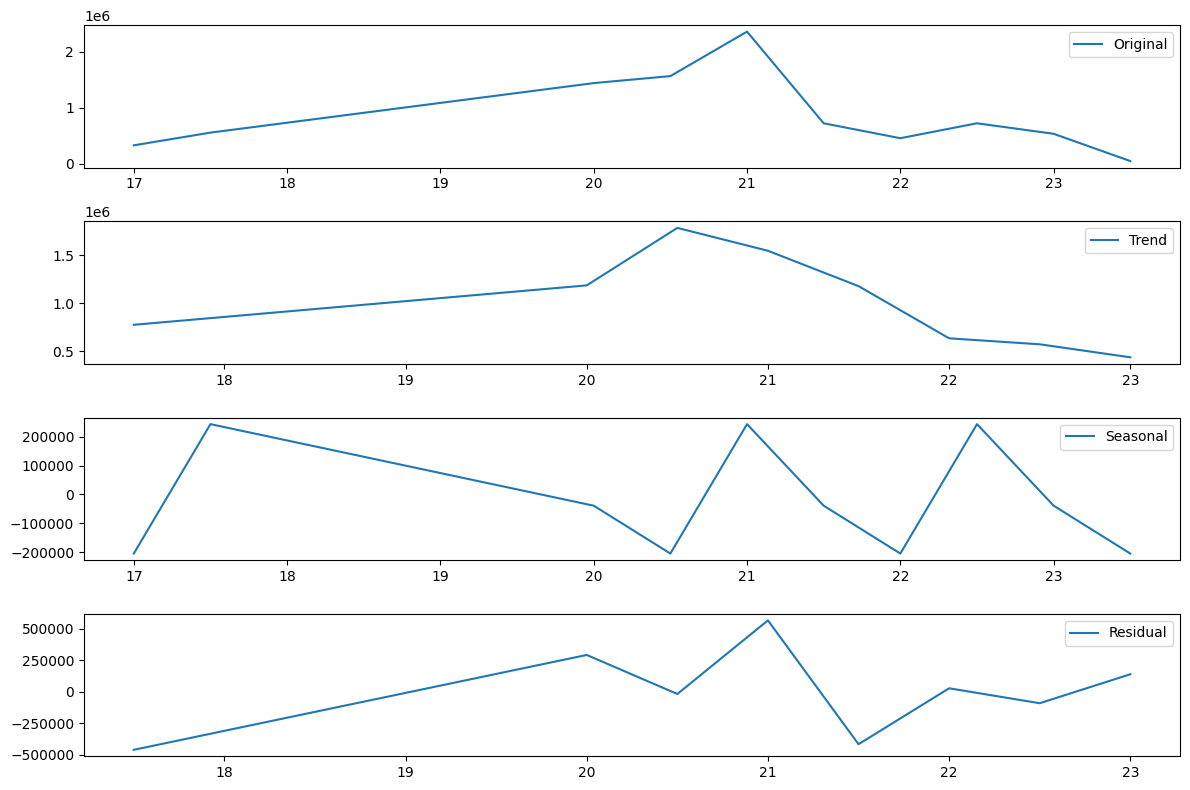


Extreme Residuals:
Series([], Name: resid, dtype: float64)

Time-Series Analysis Interpretation:
The time-series decomposition reveals the trend, seasonal, and residual components of traffic volume.
Trend component shows long-term progression of traffic volume over time.
Seasonal component reveals regular patterns or cycles of traffic volume within the given time interval.
Residual component shows irregular fluctuations or anomalies in traffic volume that are not explained by the trend or seasonal components.
Identifying spikes or dips in the residual component can help detect unusual traffic patterns or potential network anomalies.

Additional Analysis:
Mean Trend: 1015658.5833333333
Max Trend: 1787478.6666666665
Min Trend: 437166.6666666666

Mean Seasonal: -20414.84074074075
Mean Residual: 4169.740740740832
Max Residual: 565781.9629629632
Min Residual: -461506.70370370365
Standard Deviation of Residual: 342356.9421418987


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')

# Convert Unix timestamps to datetime and aggregate data in 30-minute intervals
df['flowStart_datetime'] = pd.to_datetime(df['flowStart'], unit='s')
df['hour'] = df['flowStart_datetime'].dt.hour
df['minute'] = df['flowStart_datetime'].dt.minute
df['time_interval'] = df['hour'] + df['minute'] // 30 * 0.5

# Aggregate data over 30-minute intervals
interval_volume = df.groupby('time_interval').agg({'pktTotalCount': 'sum', 'octetTotalCount': 'sum'}).reset_index()

# Scaling data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(interval_volume[['pktTotalCount', 'octetTotalCount']])

# Elbow Method to determine the optimal number of clusters
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K')
plt.show()

# Apply KMeans clustering for k=2 and k=3
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_3 = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters_2 = kmeans_2.fit_predict(scaled_data)
clusters_3 = kmeans_3.fit_predict(scaled_data)

# Visualization of clusters for k=2
plt.figure(figsize=(10, 6))
plt.scatter(interval_volume['time_interval'], interval_volume['pktTotalCount'], c=clusters_2, s=100, cmap='viridis')
plt.xlabel('Time Interval (30-minute)')
plt.ylabel('Packet Count')
plt.title('30-Minute Interval Traffic Volume Clusters (k=2)')
plt.show()

# Visualization of clusters for k=3
plt.figure(figsize=(10, 6))
plt.scatter(interval_volume['time_interval'], interval_volume['pktTotalCount'], c=clusters_3, s=100, cmap='viridis')
plt.xlabel('Time Interval (30-minute)')
plt.ylabel('Packet Count')
plt.title('30-Minute Interval Traffic Volume Clusters (k=3)')
plt.show()

# Calculate and print the average packet count for each cluster (k=2 and k=3)
for k, clusters in zip([2, 3], [clusters_2, clusters_3]):
    print(f"\nAverage packet count for clusters (k={k}):")
    for i in range(k):
        avg_pkt_count = interval_volume[clusters == i]['pktTotalCount'].mean()
        print(f"Cluster {i}: {avg_pkt_count}")

# Determine the start and end time for the dataset
start_time = df['flowStart_datetime'].min()
end_time = df['flowStart_datetime'].max()
total_hours = (end_time - start_time).total_seconds() / 3600

# Set the period for seasonal decomposition based on the data coverage
period = int(total_hours // 2)  # Ensuring at least two complete cycles

# Decompose the time series with the adjusted period
time_series = interval_volume.set_index('time_interval')['pktTotalCount']
result = seasonal_decompose(time_series, model='additive', period=period)

# Extract Components: Trend, Seasonal, and Residual
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the individual components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Identify extreme values in the residual component
extreme_residuals = residual[(residual > residual.mean() + 3 * residual.std()) | (residual < residual.mean() - 3 * residual.std())]
print("\nExtreme Residuals:")
print(extreme_residuals)

# Interpretation of Time-Series Analysis
print("\nTime-Series Analysis Interpretation:")
print("The time-series decomposition reveals the trend, seasonal, and residual components of traffic volume.")
print("Trend component shows long-term progression of traffic volume over time.")
print("Seasonal component reveals regular patterns or cycles of traffic volume within the given time interval.")
print("Residual component shows irregular fluctuations or anomalies in traffic volume that are not explained by the trend or seasonal components.")
print("Identifying spikes or dips in the residual component can help detect unusual traffic patterns or potential network anomalies.")

# Additional analysis and interpretation
print("\nAdditional Analysis:")
print(f"Mean Trend: {trend.mean()}")
print(f"Max Trend: {trend.max()}")
print(f"Min Trend: {trend.min()}")
print(f"\nMean Seasonal: {seasonal.mean()}")
print(f"Mean Residual: {residual.mean()}")
print(f"Max Residual: {residual.max()}")
print(f"Min Residual: {residual.min()}")
print(f"Standard Deviation of Residual: {residual.std()}")


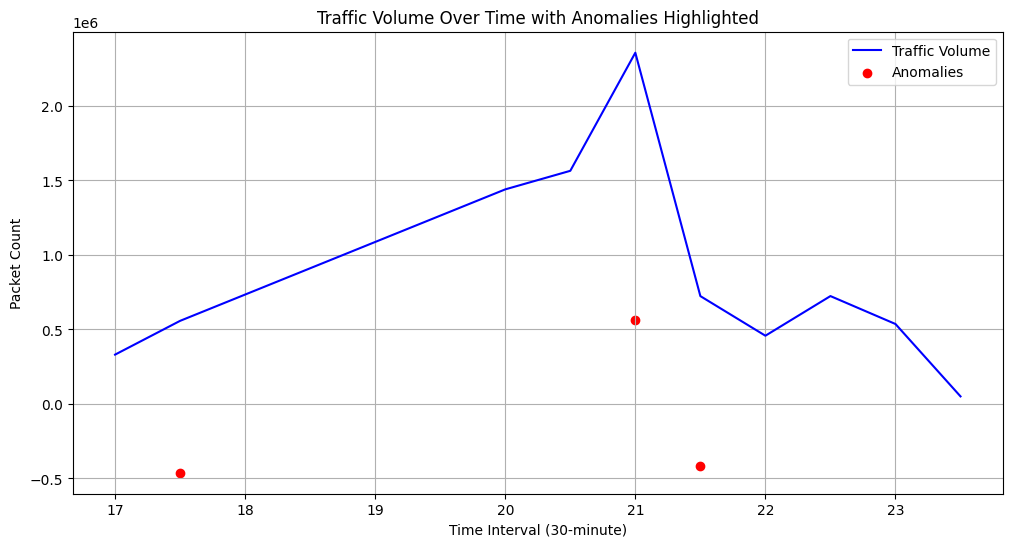


Identified Anomalies:
time_interval
17.5   -461506.703704
21.0    565781.962963
21.5   -417124.703704
Name: resid, dtype: float64


In [104]:
# Define a threshold for anomalies (e.g., 3 standard deviations from the mean)
threshold = 1 * residual.std()

# Identify extreme values in the residual component as anomalies
anomalies = residual[(residual > threshold) | (residual < -threshold)]

# Plot the traffic volume over time and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, label='Traffic Volume', color='blue')
plt.scatter(anomalies.index, anomalies.values, c='red', marker='o', label='Anomalies')
plt.xlabel('Time Interval (30-minute)')
plt.ylabel('Packet Count')
plt.title('Traffic Volume Over Time with Anomalies Highlighted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print the identified anomalies
print("\nIdentified Anomalies:")
print(anomalies)


In [92]:
# Calculate the mean and standard deviation of pktTotalCount in the dataset
mean_pktTotalCount = df['pktTotalCount'].mean()
std_pktTotalCount = df['pktTotalCount'].std()

mean_pktTotalCount, std_pktTotalCount


(87.44663, 1519.3431843493297)

<ipython-input-134-4bb147c3f7c6>:6: DtypeWarning: Columns (0,2,4,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


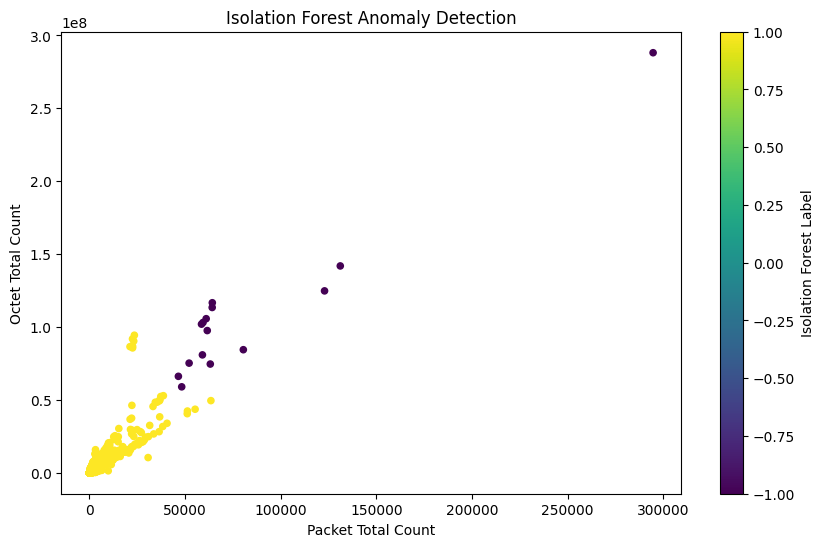

Number of anomalies detected: 15


In [134]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Unicauca-dataset-April-June-2019-Network-flows-100000rows(ALLFEATURES).csv')

# Selecting relevant features and normalizing
features = ['pktTotalCount', 'octetTotalCount']
df_selected = df[features].fillna(df[features].mean())

# Applying Isolation Forest with lower contamination parameter
iso_forest = IsolationForest(contamination=0.0001, random_state=42)
iso_forest_labels = iso_forest.fit_predict(df_selected)

# Create a plot to visualize the Isolation Forest labels
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['pktTotalCount'], df_selected['octetTotalCount'], c=iso_forest_labels, cmap='viridis', s=20)
plt.xlabel('Packet Total Count')
plt.ylabel('Octet Total Count')
plt.title('Isolation Forest Anomaly Detection')
plt.colorbar(label='Isolation Forest Label')
plt.show()
# Count the number of anomalies
num_anomalies = (iso_forest_labels == -1).sum()
print(f"Number of anomalies detected: {num_anomalies}")
